---
title: "Forecaster Prediction Performance"
author: "Michelle Gelman"
date: "04/21/2025"
format: 
  html:
    code-fold: true
    execute:
      eval: false
      echo: True
      cache: True
jupyter: python3
---

In [1]:
%%capture
from tqdm import tqdm
from convokit import Corpus, Speaker, Utterance
from collections import defaultdict
import pandas as pd
import pprint as pp
from IPython.display import display
from modules.DataPreprocesser import DataPreprocesser
from modules import CorpusUtils as corp
import torch
import pickle

# Add the src directory to the path
import sys
import os

# Add the src
sys.path.append(os.path.abspath("."))
import import_ipynb

#Convokit Imports
from convokit.forecaster.CRAFTModel import CRAFTModel
from convokit.forecaster.forecaster import Forecaster

### Todo:
- [ ] Fighting words for impasse and success disputes
- [ ] A [paper](https://arxiv.org/pdf/1805.05345) from paper from Jonathan P. Cheng (Horizon paper) that preceeeds the CRAFT model defines pragmatic devices—such as politeness strategies and rhetorical prompts—used to start a conversation, and analyze their relation to its future trajectory.
    - [ ] Convokit has a [notebook](https://github.com/CornellNLP/ConvoKit/blob/master/examples/conversations-gone-awry/Conversations_Gone_Awry_Prediction.ipynb) (very recent-2025) that creates Prompt Types/politeness strategy labels for paired utterances to make derailement predicitons
- [ ] Plot utterances frequenices across context length dimension (averaged across all conversations)
- [ ] downsample KODIS (balanced) -> check performance
- [ ] fine-tune wiki on KODIS -> check performance

### Performance Considerations:
- Is the relative horizon (normalizing for conversation length) for forcasting derailement in KODIS disputes similar to the horizon for WIKI and  CMV test dialogues?
- How early is "good enough" for us? 
- Our tokenized utterances are very short (avg.len 23) vs 84/123. Is our in-vitro dispute comprable to other dispute datasets or are these confounding factors influencing the length of negotiation utterances? Shorter utterances influence CRAFT's performance significantly?

# Creating KODIS Corpus Object

### Create Corpus

In [2]:
filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv"
final_data = DataPreprocesser(filepath)
test_corp= corp.corpusBuilder(final_data)

/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


2107


27498it [00:00, 58402.13it/s]


In [3]:
test_corp.print_summary_stats()

Number of Speakers: 4214
Number of Utterances: 27498
Number of Conversations: 2107


### Add conversation lengths as conversation metadata
- 1 is "impasse"
- 0 is "success"

In [4]:
for convo in test_corp.iter_conversations():
    convo_len = len(convo.get_utterance_ids())  # Count utterances in the conversation
    convo.add_meta("convo_len", convo_len)      # Store as conversation-level metadata
    some_convo = test_corp.get_conversation("utt0_con0")
print("Length of conversation:", some_convo.retrieve_meta("convo_len"))

Length of conversation: 14


### Add Conversation Labels from Final Pre-processed Dataframe as conversation metadata

In [5]:
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
    label = row["dispute_outcome"]  # update if your label column is named differently
    if convo_id in test_corp.conversations:
        test_corp.get_conversation(convo_id).meta["label"] = label

# Creating Forecaster and Model Objects

### CMV Model and Forecaster Object for KODIS

In [17]:
%%capture 
model2 = CRAFTModel(
    initial_weights= "craft-cmv-finetuned",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)

In [18]:
# Use 'label' because we added it to conversation.meta["label"]
forecaster2 = Forecaster(
    forecaster_model=model2,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

### Wiki Model and Forecaster Object for KODIS

In [15]:
%%capture 
model = CRAFTModel(
    initial_weights= "craft-wiki-finetuned",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)

In [16]:
# Use 'label' because we added it to conversation.meta["label"]
forecaster = Forecaster(
    forecaster_model=model,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

### Forcaster Object for CMV and WIKI

In [10]:
forecaster_cmv = Forecaster(
    forecaster_model=model2,
    labeler="has_removed_comment",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

forecaster_wiki = Forecaster(
    forecaster_model=model,
    labeler="conversation_has_personal_attack",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

# Model Weight Info

### **craft‑pretrained**

- Contains only the utterance and context encoder layers pre‑trained on the CGA‑Wikipedia or CGA-CMV data (via next‑comment prediction), but its classifier head (the SingleTargetClf) is still at its random initialization.

- Intended as a starting point if you want to fine‑tune CRAFT on your own conversational data (you’ll call fit to learn the classifier weights).

### **craft‑finetuned** (used)
- Builds on the above by having already fine‑tuned the entire network (including the classifier head).
- Ready for inference only—you can call transform immediately and get sensible forecasts without any further training.

In [11]:
display(model._config)

{'dropout': 0.1,
 'batch_size': 64,
 'clip': 50.0,
 'learning_rate': 1e-05,
 'print_every': 10,
 'finetune_epochs': 30,
 'validation_size': 0.2}

# Comparing fine-tuned Models on KODIS Corpus

### Running predictions on both fine-tuned wiki and cmv CRAFT models temporally on all utterances

In [19]:
%%capture 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


# corpusBuilder should return a ConvoKit Corpus
corp1 = corp.corpusBuilder(final_data)
corp2 = corp.corpusBuilder(final_data)

# Assign conversation-level labels
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"
    label = row["dispute_outcome"]
    if convo_id in corp1.conversations:
        corp1.get_conversation(convo_id).meta["label"] = label
    if convo_id in corp2.conversations:
        corp2.get_conversation(convo_id).meta["label"] = label

# # 2. Initialize two forecasters with different CRAFT weights
# device = "cuda" if torch.cuda.is_available() else "cpu"
# craft_wiki = CRAFTModel("craft-wiki-finetuned", torch_device=device)
# craft_cmv  = CRAFTModel("craft-cmv-finetuned",  torch_device=device)
# forecaster1 = Forecaster(craft_wiki, "label")
# forecaster2 = Forecaster(craft_cmv,  "label")



# 4. Transform both corpora
corp1 = forecaster.transform(corp1)
corp2 = forecaster2.transform(corp2)


### Getting average derailement prediction and frequency of forecast probabilities across all utterances
- Prediciton is *per utterance* on surface, but CRAFT model behind-the-scenes makes predicitons on encoded contexts which contain the conversation history up to current utterance. 
- See [Predictor Class](https://github.com/CornellNLP/ConvoKit/blob/master/convokit/forecaster/CRAFT/runners.py#L15) in runnery.py for CRAFT model
- We get the frequency of KODIS utterances across 50 probabilities [0, .02, .04, ...,1] binned from the  predicited probabilities of each utterance by the fine-tuned cmv and fine-tuned wiki model

### **Insights**
- craft-wiki tends to 

**TODO** Make 3D plot, add another dimension for the length of current context (collapse by coversation by averaging over all convos that have that context length)

Summary statistics for forecast probabilities:
           mean_prob  std_prob  median_prob
corp-wiki   0.440724  0.267856     0.381885
corp-cmv    0.541044  0.271951     0.528305


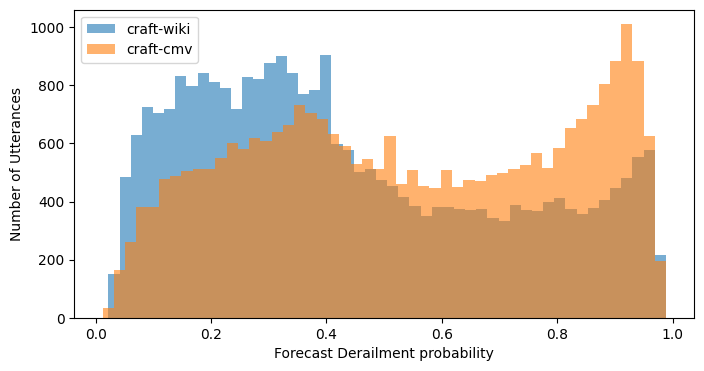

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# 1) extract the utterance‑level DataFrames from the two corpora
utt_df1 = corp1.get_utterances_dataframe()
utt_df2 = corp2.get_utterances_dataframe()


# 5. Keep only the forecast columns and drop NA
forecast_df1 = utt_df1[['meta.prediction', 'meta.pred_score']].dropna()
forecast_df2 = utt_df2[['meta.prediction', 'meta.pred_score']].dropna()

# 6. Summary statistics
summary = pd.DataFrame({
    'mean_prob':  [forecast_df1['meta.pred_score'].mean(),  forecast_df2['meta.pred_score'].mean()],
    'std_prob':   [forecast_df1['meta.pred_score'].std(),   forecast_df2['meta.pred_score'].std()],
    'median_prob':[forecast_df1['meta.pred_score'].median(),forecast_df2['meta.pred_score'].median()],
}, index=['corp-wiki', 'corp-cmv'])
print("Summary statistics for forecast probabilities:")
print(summary)

# 7. Plot histograms
plt.figure(figsize=(8,4))
plt.hist(forecast_df1['meta.pred_score'], bins=50, alpha=0.6, label='craft-wiki')
plt.hist(forecast_df2['meta.pred_score'], bins=50, alpha=0.6, label='craft-cmv')
plt.xlabel('Forecast Derailment probability')
plt.ylabel('Number of Utterances')
plt.legend()
plt.show()


### Conversation-level AUC and PR Curves
to create these plots, I looked at [Forecasters](https://github.com/CornellNLP/ConvoKit/blob/master/convokit/forecaster/forecaster.py#L139) code for aggregating utternce-levele metrics on a conversation level where:

- np.max(forecast_scores) is highest probability the model ever assigned to any utterance in this conversation
- np.max(forecasts) is if the model ever cross its decision threshold and predict 1 (derailement) for thsi conversation

### **Insights**
- Baseline positive class rate (impasse dispute) for KODIS is 17.6% out of current 2107 disputes.

**PR Curve**

-  Bottoms out at baseline impasse rate with lower decision thresholds. Essesntially, as I lower decision threshold (less confident about classifying impasse) ->  **it mispredicts impasse a lot more for successful conversations since higher recall -> less chance of 0(success) outcome**. Therefore, model is as good as random classifier as it predicts the baseline derailment rate from the sample.  Probably due to high impassee/success class imbalance.

- wiki model outperforms cmv model acrosss all decision thresholds, so it does better overall with getting successful disputes right


**AUC Curve**

-  AUC still looks high for both bc of the class imbalance for derailement disputes I think-- so this may be misleading currently

    - need to downsample and check if we do better than random 

meta.label
0    1736
1     371
Name: count, dtype: int64

Positive class rate (Derailement): 17.61%
Baseline accuracy (derailement): 0.176


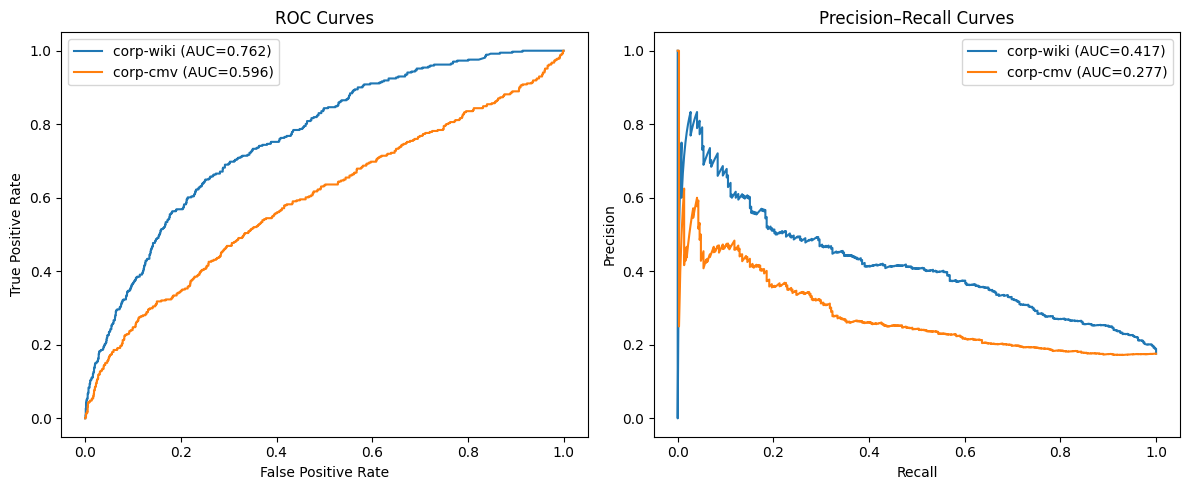

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np

def get_conv_level_scores(corpus):
    # 1) grab all utterances with a forecast
    utt = (corpus
            .get_utterances_dataframe()[['conversation_id','meta.pred_score']]
            .dropna())
    conv_scores = utt.groupby('conversation_id')['meta.pred_score'].max()
    conv_df = corpus.get_conversations_dataframe()
    conv_scores = conv_scores.reindex(conv_df.index, fill_value=0)
    y_true = conv_df['meta.label'].astype(int)
    y_scores = conv_scores.values
    return y_true, y_scores

def print_baseline_accuracy(corpus, label_field="label"):
    # pull out the conversation‑level labels
    conv_df = corpus.get_conversations_dataframe()[[f"meta.{label_field}"]]
    
    # count each class
    counts = conv_df["meta.label"].value_counts()
    min_label = counts.idxmin()    
    min_count = counts.min()      
    total     = counts.sum()
    baseline_acc = min_count / total
    print(f"Baseline accuracy (derailement): {baseline_acc:.3f}")
    


conv_df = corp1.get_conversations_dataframe()[[f"meta.label"]]
display(conv_df["meta.label"].value_counts())
y1, s1 = get_conv_level_scores(corp1)
y2, s2 = get_conv_level_scores(corp2)

positive_rate = np.mean(y1)
print(f"Positive class rate (Derailement): {positive_rate:.2%}")
print_baseline_accuracy(corp1)

# compute ROC and PR metrics
fpr1, tpr1, _    = roc_curve(y1, s1)
roc_auc1         = auc(fpr1, tpr1)
fpr2, tpr2, _    = roc_curve(y2, s2)
roc_auc2         = auc(fpr2, tpr2)

prec1, rec1, _   = precision_recall_curve(y1, s1)
pr_auc1          = auc(rec1, prec1)
prec2, rec2, _   = precision_recall_curve(y2, s2)
pr_auc2          = auc(rec2, prec2)

# plot side‑by‑side
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12,5))

# ROC panel
ax_roc.plot(fpr1, tpr1, label=f'corp-wiki (AUC={roc_auc1:.3f})')
ax_roc.plot(fpr2, tpr2, label=f'corp-cmv (AUC={roc_auc2:.3f})')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves')
ax_roc.legend()

# PR panel
ax_pr.plot(rec1, prec1, label=f'corp-wiki (AUC={pr_auc1:.3f})')
ax_pr.plot(rec2, prec2, label=f'corp-cmv (AUC={pr_auc2:.3f})')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision–Recall Curves')
ax_pr.legend()

plt.tight_layout()
plt.show()

### Comparing forcaster summaries for both fine-tuned wiki and cmv CRAFT models predictions
- Ran using Forecasters summarize function for conversation-level statistics

- both reddit and cmv have **Utterance-level labels for derailed comment** as well as classify derailment on a conversation level if the conversation contains a derailement comment.

### Insights

**Forecast Horizon: "How early can we detect derailement?"**

- This measures the number of utterances after the derailed utterance the model predicted in a coversation.

- Since our dataset has an average length of 13.5 utterances, the forecast horizon on average is 9.72 and 10 respecitvely for the WIKI and cmv models, meaning derailement is forecast towards the end of a KODIS dispute.


**Conversation Metrics**
- On a conversation-level, accuracy of predicting derailement is pretty low and F1 scores are low for both fine-tuned models

- **Accuracy**: The model mispredicts derailements most of the time (for success class mainly) - out of 2017 disputes, 45% and 24% were wrongly flagged as derailed. -> low Accuracy

- **Recall**: Models are very sensitive to derailement events and for all actual derailed disputes, it correctly flags them -> high Recall

- **FPR**: Since there are many successul disputes (majority class), the models flag a lot of them as derailed -> high FPR

**Calibration Curves**

- both models underperform

The above is why the "good" AUC curve is misleading I think

In [26]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
horizon_kwiki = forecaster._draw_horizon_plot(corp1)
horizon_kcmv  = forecaster2._draw_horizon_plot(corp2)
conv_kwiki, metrics1_kwiki = forecaster.summarize(corp1)
conv_kcmv, metrics2_kcmv = forecaster2.summarize(corp2)

Average conversation length in KODIS is: 13.05 utterances

-------------------
OVERALL STATS FOR KODIS PREDICTIONS 
-------------------


,Accuracy,Precision,Recall,FPR,F1
model_wiki,0.450403,0.233220,0.927224,0.651498,0.372698
model_cmv,0.240152,0.174603,0.889488,0.898618,0.291906


'wiki model horizon stats:  Mean = 9.723837209302326, Median = 9.0'

'cmv model horizon stats: Mean = 10.006060606060606, Median = 9.0'

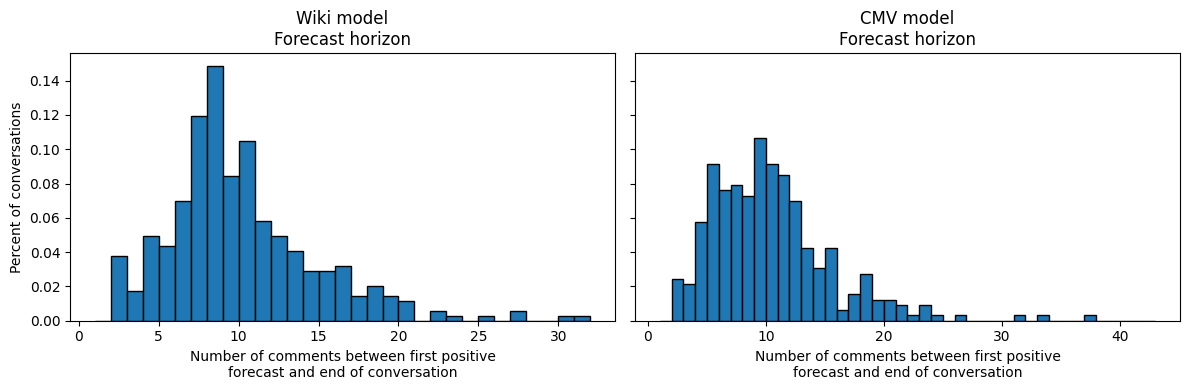

Agreement rate between wiki vs. cmv predictions: 69.96%

Disagreement breakdown (wiki  vs. cmv ):
cmv_pred   0.0  1.0
wiki_pred          
0.0          0  524
1.0        109    0




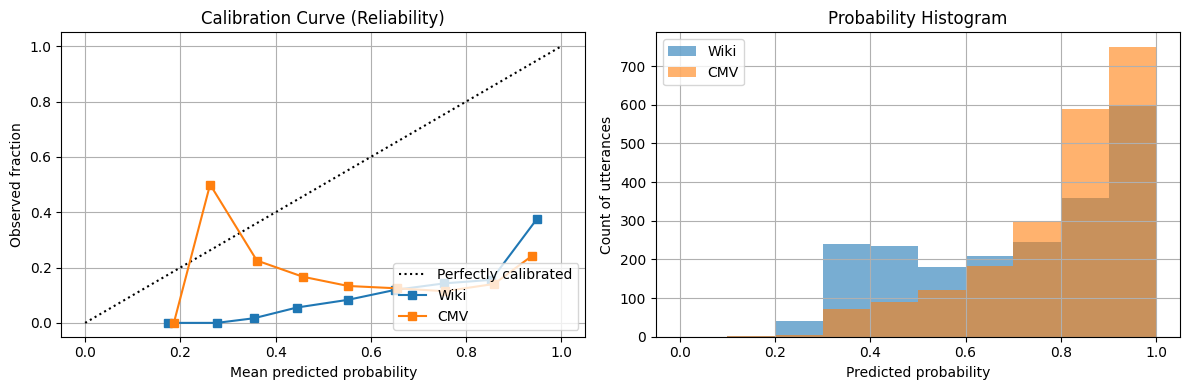

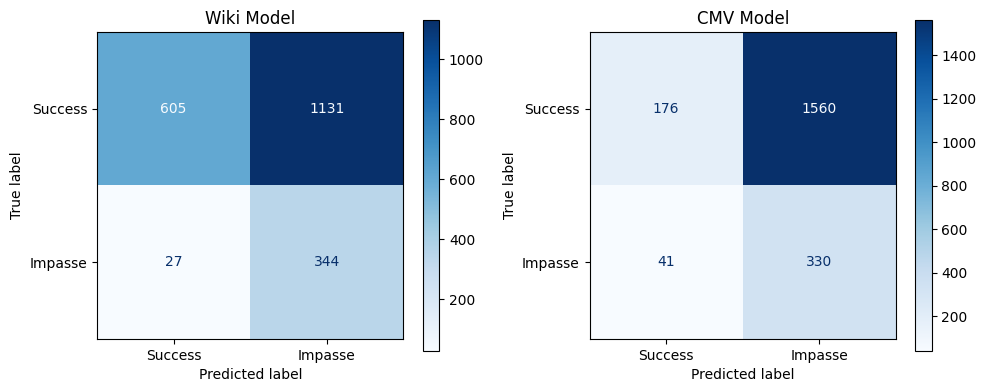


Summary statistics:


,wiki_acc,cmv_acc,agreement_rate,wiki_avg_prob,cmv_avg_prob
utterance_level,0.450403,0.240152,0.699573,0.708614,0.801742


In [30]:
import pandas as pd
from IPython.display import display

lengths = [
    len(convo.get_utterance_ids())
    for convo in corp2.iter_conversations()
]
avg_len = sum(lengths) / len(lengths)
print(f"Average conversation length in KODIS is: {avg_len:.2f} utterances")

print("\n-------------------")
print("OVERALL STATS FOR KODIS PREDICTIONS \n-------------------")
metrics_df = pd.DataFrame([metrics1_kwiki, metrics2_kcmv], index=['model_wiki','model_cmv'])
display(metrics_df)


vals_kwiki = np.array(list(horizon_kwiki.values()))
vals_kcmv  = np.array(list(horizon_kcmv.values()))

max_kwiki = vals_kwiki.max() if vals_kwiki.size else 1
max_kcmv  = vals_kcmv.max()  if vals_kcmv.size  else 1

bins_kwiki = range(1, max_kwiki)
bins_kcmv  = range(1, max_kcmv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ax1.hist(vals_kwiki, bins=bins_kwiki, density=True, edgecolor="k")
ax1.set_title("Wiki model\nForecast horizon")
ax1.set_xlabel("Number of comments between first positive\nforecast and end of conversation")
ax1.set_ylabel("Percent of conversations")

ax2.hist(vals_kcmv, bins=bins_kcmv, density=True, edgecolor="k")
ax2.set_title("CMV model\nForecast horizon")
ax2.set_xlabel("Number of comments between first positive\nforecast and end of conversation")
display("wiki model horizon stats:  Mean = 9.723837209302326, Median = 9.0")
display("cmv model horizon stats: Mean = 10.006060606060606, Median = 9.0")
plt.tight_layout()
plt.show()


# 3) Merge the two conversation‐level forecasts side by side
conv1 = conv_kwiki.rename(columns={'label':'label','score':'score_wiki','forecast':'forecast_wiki'})
conv2 = conv_kcmv.rename(columns={'score':'score_cmv','forecast':'forecast_cmv'})

# join on conversation_id
merged = conv1.join(conv2[['score_cmv','forecast_cmv']], how='inner')
# print("=== Conversation‑level forecasts comparison ===")
# display(merged)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
from IPython.display import display


# 1) Compute agreement flag
merged['match'] = merged['forecast_wiki'] == merged['forecast_cmv']

# 2) Overall agreement rate
agree_rate = merged['match'].mean()
print(f"Agreement rate between wiki vs. cmv predictions: {agree_rate:.2%}\n")

# 3) Where they disagree
print("Disagreement breakdown (wiki  vs. cmv ):")
print(pd.crosstab(
    merged.loc[~merged['match'], 'forecast_wiki'],
    merged.loc[~merged['match'], 'forecast_cmv'],
    rownames=['wiki_pred'], colnames=['cmv_pred']
))
print("\n")

# 4) Calibration + histogram side by side
fig, (ax_cal, ax_hist) = plt.subplots(1, 2, figsize=(12, 4))

# 4a) overlayed calibration curves on the left
CalibrationDisplay.from_predictions(
    y_true=merged['label'],
    y_prob=merged['score_wiki'],
    n_bins=10,
    name="Wiki",
    ax=ax_cal
)
CalibrationDisplay.from_predictions(
    y_true=merged['label'],
    y_prob=merged['score_cmv'],
    n_bins=10,
    name="CMV",
    ax=ax_cal
)
ax_cal.set_title("Calibration Curve (Reliability)")
ax_cal.set_xlabel("Mean predicted probability")
ax_cal.set_ylabel("Observed fraction")
ax_cal.legend(loc="lower right")
ax_cal.grid(True)

# 4b) probability‐histogram on the right
bins = np.linspace(0, 1, 11)
ax_hist.hist(merged['score_wiki'], bins=bins, alpha=0.6, label='Wiki')
ax_hist.hist(merged['score_cmv'],  bins=bins, alpha=0.6, label='CMV')
ax_hist.set_title("Probability Histogram")
ax_hist.set_xlabel("Predicted probability")
ax_hist.set_ylabel("Count of utterances")
ax_hist.legend()
ax_hist.grid(True)

plt.tight_layout()
plt.show()


# 5) Confusion matrices side by side
fig, (ax_wiki, ax_cmv) = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(
    y_true=merged['label'],
    y_pred=merged['forecast_wiki'],
    display_labels=["Success", "Impasse"],
    cmap='Blues',
    ax=ax_wiki
)
ax_wiki.set_title("Wiki Model")

ConfusionMatrixDisplay.from_predictions(
    y_true=merged['label'],
    y_pred=merged['forecast_cmv'],
    display_labels=["Success", "Impasse"],
    cmap='Blues',
    ax=ax_cmv
)
ax_cmv.set_title("CMV Model")

plt.tight_layout()
plt.show()

# 6) Summary table
summary = pd.DataFrame({
    'wiki_acc':       [(merged['label'] == merged['forecast_wiki']).mean()],
    'cmv_acc':        [(merged['label'] == merged['forecast_cmv']).mean()],
    'agreement_rate': [agree_rate],
    'wiki_avg_prob':  [merged['score_wiki'].mean()],
    'cmv_avg_prob':   [merged['score_cmv'].mean()],
}, index=['utterance_level'])
print("\nSummary statistics:")
display(summary)



In [29]:
print(merged['label'].value_counts())
print(merged['forecast_wiki'].value_counts())
print(merged['forecast_cmv'].value_counts())

label
0    1736
1     371
Name: count, dtype: int64
forecast_wiki
1.0    1475
0.0     632
Name: count, dtype: int64
forecast_cmv
1.0    1890
0.0     217
Name: count, dtype: int64


### Average length of tokenized utterances for wiki test , cmv test, and kodis corpora from CRAFT tokenization scheme
- CRAFT has max tokenization length of 80 tokens per utterance. Is this relevant to the performance in anyway? More specifically:
    - what are the tokenization lengths of the utterances for the data used in the train sets for CMV and Wiki?
    - what is the average tokenization length for a KODIS utterance?

Is it even relevant to affecting performance, and how to measure this?

In [ ]:
from convokit import download, Corpus


corpus_cmv = Corpus("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convokit_datasets/conversations-gone-awry-cmv-corpus")
corpus_wiki = Corpus("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convokit_datasets/conversations-gone-awry-corpus")

In [ ]:
convo_ex =  next(corpus_wiki.iter_conversations())
print("Conversation Meta data for wiki conversation \n"
"======================")
for key, val in convo_ex.meta.items():
  
    print(f"{key:20s} → {val}")


print("\n")
convo_ex2 =  next(corpus_cmv.iter_conversations())
print("Conversation Meta data for cmv conversation \n "
"======================")
for key, val in convo_ex2.meta.items():
    print(f"{key:20s} → {val}")


Conversation Meta data for wiki conversation 
page_title           → User talk:2005
page_id              → 1003212
pair_id              → 143890867.11926.11926
conversation_has_personal_attack → False
verified             → True
pair_verified        → True
annotation_year      → 2018
split                → train


Conversation Meta data for cmv conversation 
pair_id              → cue8uxd
has_removed_comment  → True
split                → train
summary_meta         → []


In [ ]:
import os
import numpy as np
from convokit import download, Corpus
from convokit.forecaster.CRAFT.data import (
    loadPrecomputedVoc,
    tokenize,
    Voc,
)

'''
Need to get only the utterances used for training fine-tuned model. 
Choose only those utterances in conversations where mete.split == train
'''

def load_craft_vocab(model_name: str) -> Voc:
    base = download(model_name, data_dir=os.path.expanduser("~/.convokit/models"))
    return loadPrecomputedVoc(
        model_name,
        os.path.join(base, "word2index.json"),
        os.path.join(base, "index2word.json"),
    )


voc_wiki = load_craft_vocab("craft-wiki-finetuned")
voc_cmv  = load_craft_vocab("craft-cmv-finetuned")


In [ ]:
"""
    Walk through all conversations in `corpus`, select only those with
    convo.meta["split"] == split, tokenize each utterance via CRAFT's
    tokenize(voc, text), and return summary stats on token counts.
"""

def summarize_token_lengths(corpus: Corpus, voc: Voc, split: str = None):
    lengths = []
    for convo in corpus.iter_conversations():
        # if a split is specified, filter; otherwise include everything
        if split is not None and convo.meta.get("split") != split:
            continue
        for utt in convo.iter_utterances():
            toks = tokenize(voc, utt.text or "")
            lengths.append(len(toks))
    if not lengths:
        return {"n_utt": 0, "mean": np.nan, "median": np.nan, "std": np.nan}
    arr = np.array(lengths)
    return {
        "n_utt":  int(arr.size),
        "mean":   float(arr.mean()),
        "median": float(np.median(arr)),
        "std":    float(arr.std()),
    }



# -- 5) run it on all four settings --
results = {
    "craft‑wiki":   summarize_token_lengths(corpus_wiki, voc_wiki, split="train"),
    "craft‑cmv":    summarize_token_lengths(corpus_cmv,  voc_cmv,  split="train"),
    "kodis‑wiki":   summarize_token_lengths(corp1, voc_wiki),
    "kodis‑cmv":    summarize_token_lengths(corp1, voc_cmv),

}

df = pd.DataFrame(results).T.reset_index().rename(columns={"index":"vocab"})
display(df)

,vocab,n_utt,mean,median,std
0,craft‑wiki,18042.0,82.001330,47.0,139.549799
1,craft‑cmv,25885.0,123.472474,72.0,166.329963
2,kodis‑wiki,27498.0,24.159939,20.0,20.964779
3,kodis‑cmv,27498.0,24.159939,20.0,20.964779


# Compare Predictions on test sets for CMV and WIKI datasets using respecitve fine-tuned CRAFT Models 
- for reproducability, need to check if any additions since 2018 for wiki data as it is public and growing. reddit cmv was created specifically for this paper, so no updates expected.

In [37]:
def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    return (context_tuple.current_utterance.get_conversation().meta["split"] == "test")

corpus_cmv = Corpus("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convokit_datasets/conversations-gone-awry-cmv-corpus")
corpus_wiki = Corpus("/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/convokit_datasets/conversations-gone-awry-corpus")

In [ ]:
corp_test_wiki = forecaster_wiki.transform(corpus_wiki, context_selector= transform_selector)
corp_test_cmv = forecaster_cmv.transform(corpus_cmv, context_selector= transform_selector)

In [39]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
test_selector = lambda c: c.meta.get("split") == "test"
horizon_wiki = forecaster_wiki._draw_horizon_plot(corp_test_wiki, test_selector)
horizon_cmv  = forecaster_cmv._draw_horizon_plot(corp_test_cmv, test_selector)
conv_df1, metrics1 = forecaster_wiki.summarize(corp_test_wiki,  lambda c: c.meta['split'] == "test")
conv_df2, metrics2 = forecaster_cmv.summarize(corp_test_cmv,  lambda c: c.meta['split'] == "test")

Average conversation length in test WIKI is: 7.17 utterances
Average conversation length in test CMV is: 6.28 utterances

-------------------
OVERALL STATS FOR TEST SET PREDICTIONS 
 -------------------


,Accuracy,Precision,Recall,FPR,F1
corp_wiki_test,0.704762,0.638264,0.945238,0.535714,0.761996
copr_cmv_test,0.620614,0.589967,0.790936,0.549708,0.675828


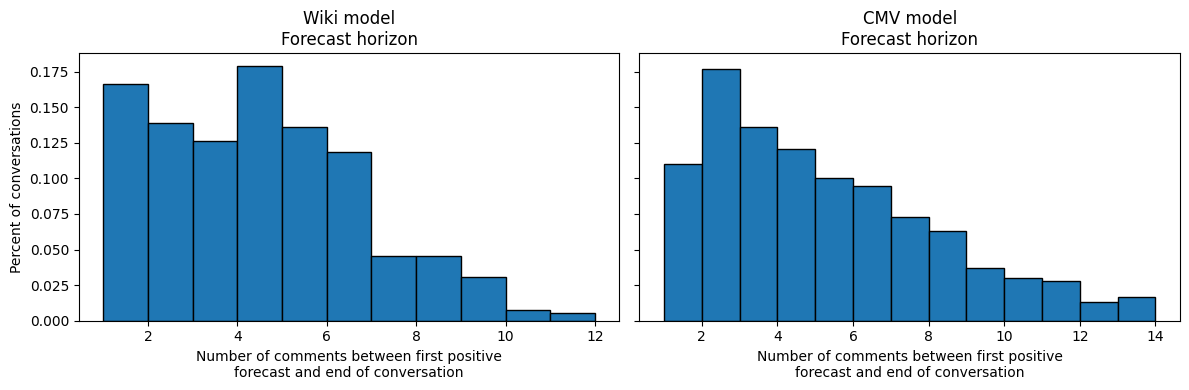

In [45]:

lengths_cmv = [
    len(convo.get_utterance_ids())
    for convo in corp_test_cmv.iter_conversations()
]
lengths_wiki = [
    len(convo.get_utterance_ids())
    for convo in corp_test_wiki.iter_conversations()
]
avg_len_cmv = sum(lengths_cmv) / len(lengths_cmv)
avg_len_wiki = sum(lengths_wiki) / len(lengths_wiki)
print(f"Average conversation length in test WIKI is: {avg_len_wiki:.2f} utterances")
print(f"Average conversation length in test CMV is: {avg_len_cmv:.2f} utterances")
print("\n-------------------")
print("OVERALL STATS FOR TEST SET PREDICTIONS \n -------------------")
metrics_df = pd.DataFrame([metrics1, metrics2], index=['corp_wiki_test','copr_cmv_test'])
display(metrics_df)


vals_wiki = np.array(list(horizon_wiki.values()))
vals_cmv  = np.array(list(horizon_cmv.values()))

max_wiki = vals_wiki.max() if vals_wiki.size else 1
max_cmv  = vals_cmv.max()  if vals_cmv.size  else 1

bins_wiki = range(1, max_wiki)
bins_cmv  = range(1, max_cmv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ax1.hist(vals_wiki, bins=bins_wiki, density=True, edgecolor="k")
ax1.set_title("Wiki model\nForecast horizon")
ax1.set_xlabel("Number of comments between first positive\nforecast and end of conversation")
ax1.set_ylabel("Percent of conversations")

ax2.hist(vals_cmv, bins=bins_cmv, density=True, edgecolor="k")
ax2.set_title("CMV model\nForecast horizon")
ax2.set_xlabel("Number of comments between first positive\nforecast and end of conversation")

plt.tight_layout()
plt.show()